# Objectives

1. Run clock analysis.
1. Add clock stats to dataframe.

Troubleshooting:
  - Disappearing nodes?

---
# Setup

## Import Modules

In [1]:
import os # Create directories and files
import random # Set seed for stats
import copy # copy objects to prevent permanent modification

# Logging output to file
import sys
import io

# Phylogenetics
from Bio import Phylo # Tree operations
from Bio import AlignIO # Add constant sites to alignment
import treetime # Timetree operations

# JSON
import json

## Input File Paths

In [2]:
tree_path = "../../docs/results/latest/parse_tree/parse_tree.nwk"
tree_df_path = "../../docs/results/latest/mugration/mugration.tsv"
aln_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.snps.filter5.aln"
constant_sites_path = "../../docs/results/latest/snippy_multi/snippy-core_chromosome.full.constant_sites.txt"
outdir = "../../docs/results/latest/timetree/"

# Create output directory if it doesn't exist
if not os.path.exists(outdir):
    os.mkdir(outdir)

## Variables

In [3]:
from config import *

NAME_COL = "Name"
SCRIPT_NAME = "timetree"

# Random
random.seed(1152342, 2)
np.random.seed(70262122)
st0 = np.random.get_state()


In [4]:
align = AlignIO.read(aln_path, format="fasta")

In [5]:
"""constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}

with open(constant_sites_path, "r") as infile:
    constant_sites_list = infile.read().strip().split(",")
    constant_sites_dict["A"] = int(constant_sites_list[0])
    constant_sites_dict["C"] = int(constant_sites_list[1])
    constant_sites_dict["G"] = int(constant_sites_list[2])
    constant_sites_dict["T"] = int(constant_sites_list[3])    

print(constant_sites_dict)
total_constant_sites = sum(constant_sites_dict.values())
print("Constant Sites:", total_constant_sites)

# Add the constant sites to each sample
# Iterate through each samples sequence
for rec in align:
    # Iterate through each nucleotide for constant sites
    for nucleotide,count in constant_sites_dict.items():
        rec.seq = rec.seq + (nucleotide * count)"""

'constant_sites_dict = {"A": 0, "C" : 0, "G" : 0, "T" : 0}\n\nwith open(constant_sites_path, "r") as infile:\n    constant_sites_list = infile.read().strip().split(",")\n    constant_sites_dict["A"] = int(constant_sites_list[0])\n    constant_sites_dict["C"] = int(constant_sites_list[1])\n    constant_sites_dict["G"] = int(constant_sites_list[2])\n    constant_sites_dict["T"] = int(constant_sites_list[3])    \n\nprint(constant_sites_dict)\ntotal_constant_sites = sum(constant_sites_dict.values())\nprint("Constant Sites:", total_constant_sites)\n\n# Add the constant sites to each sample\n# Iterate through each samples sequence\nfor rec in align:\n    # Iterate through each nucleotide for constant sites\n    for nucleotide,count in constant_sites_dict.items():\n        rec.seq = rec.seq + (nucleotide * count)'

## Import Divergence Tree

In [6]:
tree_div = Phylo.read(tree_path, "newick")
tree_div.ladderize(reverse=False)

## Import Dataframe

In [7]:
tree_df = pd.read_csv(tree_df_path, sep='\t')
# Fix the problem with multiple forms of NA in the table
# Consolidate missing data to the NO_DATA_CHAR
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df.set_index(NAME_COL, inplace=True)

## Remove Bad Branches

Identified in the next step

In [8]:
# HOT FIX for bad branches
tmp_tree = os.path.join(outdir, "temp.nwk")

bad_samples = ["GCA_008630375.1_ASM863037v1_genomic", 
                "GCA_008630375.2_ASM863037v2_genomic", 
                "GCA_003086075.1_ASM308607v1_genomic",
                "GCA_001613865.1_ASM161386v1_genomic"]

# Prune bad samples from tree and dataframe
for sample in bad_samples:
    tree_div.prune(sample)
    tree_df.drop(index=sample, inplace=True)
    
# Save temp files
tmp_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(tmp_path_df, sep="\t")

tmp_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
Phylo.write(tree_div, tmp_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

1

## Intialize Timetree Object


Attempting to parse dates...
	Using column 'Name' as name. This needs match the taxon names in the tree!!
	Using column 'Date' as date.

0.00	-TreeAnc: set-up

0.04	-###TEST.TreeAnc.prepare_tree: BEGIN

1.21	-SequenceData: loaded alignment.
1.21	--SequenceData.aln: specified sequence length doesn't match alignment
    	  length. Treating difference as constant sites.

1.21	-SeqData: making compressed alignment...

3.98	-SequenceData: constructed compressed alignment...
4.06	---**WARNING: Number of tips in tree differs from number of sequences in
    	   alignment!**
4.30	--ClockTree: Setting precision to level 2

4.39	-ClockTree._assign_dates: assigned date contraints to 630 out of 630 tips.
4.70	--ClockTree.date2dist: Setting new molecular clock. rate=9.416e-09,
    	  R^2=0.2483

4.72	-###TEST.TreeAnc.prepare_tree: BEGIN
{'clock_rate': 9.416066712137288e-09, 'intercept': 5.304755152697907e-05, 'chisq': 2.582616029485927e-08, 'r_val': 0.49828866115420706, 'cov': None, 'sigma': 0, 'va

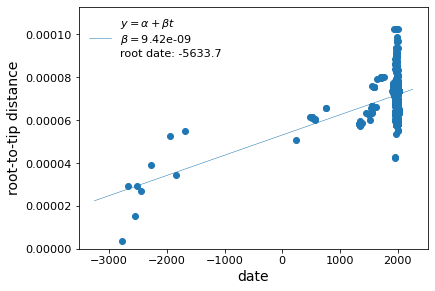

In [9]:
# Use the utils function to parse the metadata dates
dates_raw = treetime.utils.parse_dates(tmp_path_df, 
                                   date_col=DATE_COL, 
                                   name_col = NAME_COL)

# Remove nan elements (internal nodes)
dates = {}
for k,v in dates_raw.items():
    if type(v) == list:
        dates[k] = v
    elif not pd.isnull(v):
        dates[k] = v

# Construct the treetime object
# Remember, including the alignment is crucial!
tt = treetime.TreeTime(dates=dates, 
                       aln=aln_path,                     
                       tree=tmp_path_nwk, 
                       verbose=4, 
                       fill_overhangs=False,
                       seq_len=REF_LEN,                        
                      )

# Remove outliers
tt.clock_filter(reroot=None, 
                n_iqd=N_IQD, 
                plot=True,
               )

# Check rtt
print(tt.date2dist.__dict__)

---
# 1. Clock Analysis

In [10]:
# Initialize stdout capture
old_stdout = sys.stdout
new_stdout = io.StringIO()
sys.stdout = new_stdout

# PARAM MIN: root='-4101-09-02'
#tt.run()

#tt.run(time_marginal=TIME_MARGINAL)

# PARAM FULL: root=''
tt.run(
       Tc="skyline", 
       max_iter=MAX_ITER,
       relaxed_clock={"slack":5.0, "coupling": 0},
       infer_gtr=True,
       time_marginal=TIME_MARGINAL,
       sequence_marginal=SEQ_MARGINAL,
       verbose=4,
       resolve_polytomies=False,
       n_iqd=N_IQD,
       # branch_length_mode = "input",
       # root=None,
       # use_covariation=False,
       # vary_rate=False,
       )

# Save stdout to file
output = new_stdout.getvalue()
out_path = os.path.join(outdir, SCRIPT_NAME + ".log") 
with open(out_path, "w") as file:
    file.write(output)
    
# Restore stdout
sys.stdout = old_stdout
print("Standard output restored.")


5.55	-TreeTime._set_branch_length_mode: maximum branch length is 3.716e-05,
    	 using branch length mode joint

5.55	-TreeAnc.optimize_tree: sequences...

5.55	-TreeAnc.infer_ancestral_sequences with method: probabilistic, joint

5.55	WARNING: Previous versions of TreeTime (<0.7.0) RECONSTRUCTED sequences of
    	tips at positions with AMBIGUOUS bases. This resulted in unexpected
    	behavior is some cases and is no longer done by default. If you want to
    	replace those ambiguous sites with their most likely state, rerun with
    	`reconstruct_tip_states=True` or `--reconstruct-tip-states`.
5.55	--TreeAnc._ml_anc_joint: type of reconstruction: Joint
5.55	---TreeAnc._ml_anc_joint: Walking up the tree, computing likelihoods...
11.32	---TreeAnc._ml_anc_joint: Walking down the tree, computing maximum
     	   likelihood sequences...
11.54	---TreeAnc._ml_anc_joint: ...done
11.56	--TreeAnc.infer_gtr: counting mutations...
13.14	---TreeAnc.infer_gtr: counting mutations...done

13.14	-G

131.55	-TEST.ClockTree.convert_dates -- numdate: 1987.0

131.55	-TEST.ClockTree.convert_dates -- date: 1987-01-01

131.55	-TEST.ClockTree.convert_dates -- node name: NODE100
      	 years_bp161.4981490712054

131.55	-TEST.ClockTree.convert_dates -- numdate: 1859.612809832904

131.55	-TEST.ClockTree.convert_dates -- date: 1859-08-12

131.55	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_006546745.1_ASM654674v1_genomic years_bp31.11095890410957

131.56	-TEST.ClockTree.convert_dates -- numdate: 1990.0

131.56	-TEST.ClockTree.convert_dates -- date: 1990-01-01

131.56	-TEST.ClockTree.convert_dates -- node name: NODE101
      	 years_bp49.11084430617557

131.56	-TEST.ClockTree.convert_dates -- numdate: 1972.000114597934

131.56	-TEST.ClockTree.convert_dates -- date: 1972-01-01

131.56	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_002981925.1_ASM298192v1_genomic years_bp49.110958904109566

131.56	-TEST.ClockTree.convert_dates -- numdate: 1972.0

131.56	-TEST.ClockTree.conve

      	 GCA_000323705.1_ASM32370v1_genomic years_bp65.11095890410957

131.77	-TEST.ClockTree.convert_dates -- numdate: 1956.0

131.77	-TEST.ClockTree.convert_dates -- date: 1956-01-01

131.77	-TEST.ClockTree.convert_dates -- node name: NODE215
      	 years_bp115.96241160433107

131.77	-TEST.ClockTree.convert_dates -- numdate: 1905.1485472997786

131.77	-TEST.ClockTree.convert_dates -- date: 1905-02-24

131.77	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_001188675.1_ASM118867v1_genomic years_bp60.110844306175565

131.77	-TEST.ClockTree.convert_dates -- numdate: 1961.000114597934

131.77	-TEST.ClockTree.convert_dates -- date: 1961-01-01

131.77	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_002412225.1_Y.pestis_A-1486_genomic years_bp55.11095890410957

131.77	-TEST.ClockTree.convert_dates -- numdate: 1966.0

131.77	-TEST.ClockTree.convert_dates -- date: 1966-01-01

131.77	-TEST.ClockTree.convert_dates -- node name: NODE216
      	 years_bp95.09206829766848

131.77	-T

      	 GCA_000324485.1_ASM32448v1_genomic years_bp64.11095890410957

131.98	-TEST.ClockTree.convert_dates -- numdate: 1957.0

131.98	-TEST.ClockTree.convert_dates -- date: 1957-01-01

131.99	-TEST.ClockTree.convert_dates -- node name: NODE319
      	 years_bp60.2632361726014

131.99	-TEST.ClockTree.convert_dates -- numdate: 1960.8477227315082

131.99	-TEST.ClockTree.convert_dates -- date: 1960-11-06

131.99	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000324605.1_ASM32460v1_genomic years_bp51.110958904109566

131.99	-TEST.ClockTree.convert_dates -- numdate: 1970.0

131.99	-TEST.ClockTree.convert_dates -- date: 1970-01-01

131.99	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000325025.1_ASM32502v1_genomic years_bp51.110958904109566

131.99	-TEST.ClockTree.convert_dates -- numdate: 1970.0

131.99	-TEST.ClockTree.convert_dates -- date: 1970-01-01

131.99	-TEST.ClockTree.convert_dates -- node name: NODE320
      	 years_bp126.72859038154888

131.99	-TEST.ClockTree.con


132.20	-TEST.ClockTree.convert_dates -- numdate: 2003.0

132.20	-TEST.ClockTree.convert_dates -- date: 2003-01-01

132.20	-TEST.ClockTree.convert_dates -- node name: NODE421
      	 years_bp52.52560310944279

132.20	-TEST.ClockTree.convert_dates -- numdate: 1968.5853557946668

132.20	-TEST.ClockTree.convert_dates -- date: 1968-08-02

132.20	-TEST.ClockTree.convert_dates -- node name: NODE425
      	 years_bp36.48111898153802

132.20	-TEST.ClockTree.convert_dates -- numdate: 1984.6298399225716

132.20	-TEST.ClockTree.convert_dates -- date: 1984-08-18

132.20	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_001595585.1_ASM159558v1_genomic years_bp12.110958904109566

132.20	-TEST.ClockTree.convert_dates -- numdate: 2009.0

132.20	-TEST.ClockTree.convert_dates -- date: 2009-01-01

132.20	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_003085995.1_ASM308599v1_genomic years_bp7.110958904109569

132.20	-TEST.ClockTree.convert_dates -- numdate: 2014.0

132.20	-TEST.ClockTree.co

132.41	-TEST.ClockTree.convert_dates -- date: 1776-12-21

132.42	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000324825.1_ASM32482v1_genomic years_bp75.11095890410958

132.42	-TEST.ClockTree.convert_dates -- numdate: 1946.0

132.42	-TEST.ClockTree.convert_dates -- date: 1946-01-01

132.42	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000323985.1_ASM32398v1_genomic years_bp69.11095890410958

132.42	-TEST.ClockTree.convert_dates -- numdate: 1952.0

132.42	-TEST.ClockTree.convert_dates -- date: 1952-01-01

132.42	-TEST.ClockTree.convert_dates -- node name: NODE516
      	 years_bp113.11084430617558

132.42	-TEST.ClockTree.convert_dates -- numdate: 1908.000114597934

132.42	-TEST.ClockTree.convert_dates -- date: 1908-01-01

132.42	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000182505.1_ASM18250v1_genomic years_bp113.11084430617558

132.42	-TEST.ClockTree.convert_dates -- numdate: 1908.000114597934

132.42	-TEST.ClockTree.convert_dates -- date: 1908-01-01

1

132.62	-TEST.ClockTree.convert_dates -- numdate: 2010.0

132.62	-TEST.ClockTree.convert_dates -- date: 2010-01-01

132.62	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000268785.1_ASM26878v1_genomic years_bp11.110958904109564

132.62	-TEST.ClockTree.convert_dates -- numdate: 2010.0

132.62	-TEST.ClockTree.convert_dates -- date: 2010-01-01

132.62	-TEST.ClockTree.convert_dates -- node name: NODE623
      	 years_bp55.015386579914974

132.62	-TEST.ClockTree.convert_dates -- numdate: 1966.0955723241946

132.62	-TEST.ClockTree.convert_dates -- date: 1966-02-04

132.62	-TEST.ClockTree.convert_dates -- node name:
      	 GCA_000269485.1_ASM26948v1_genomic years_bp11.110958904109564

132.62	-TEST.ClockTree.convert_dates -- numdate: 2010.0

132.62	-TEST.ClockTree.convert_dates -- date: 2010-01-01

132.62	-TEST.ClockTree.convert_dates -- node name: NODE624
      	 years_bp47.06241530231853

132.62	-TEST.ClockTree.convert_dates -- numdate: 1974.0485436017912

132.62	-TEST.ClockTree.con

KeyboardInterrupt: 

In [ ]:
# Quick check 1
tt.tree.common_ancestor("NODE0")

In [ ]:
# Quick check 2
tt.clock_model

## Ladderize Tree

In [ ]:
tt.tree.ladderize(reverse=False)

---
# 2. Add clock stats to data frame

- Rates
- Dates
- RTT Regression

## Rates

In [ ]:
tree_df["timetree_rate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_rate_fold_change"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_mutation_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# The mean rate is the slope
mean_rate = tt.clock_model["slope"]

for c in tt.tree.find_clades():
    tree_df.at[c.name, "timetree_mutation_length"] = c.mutation_length
    
    # Relaxed Clock
    if hasattr(c, "branch_length_interpolator") and c.branch_length_interpolator:
        g = c.branch_length_interpolator.gamma
        tree_df.at[c.name, "timetree_rate_fold_change"] = g
        tree_df.at[c.name, "timetree_rate"] = mean_rate * g
        
    # Strict Clock
    else:
        tree_df.at[c.name, "timetree_rate_fold_change"] = 1
        tree_df.at[c.name, "timetree_rate"] = mean_rate

## Dates

In [ ]:
# Create new columns
tree_df["timetree_date"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_numdate"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Optional confidence intervals if marginal prob was run
tree_df["timetree_numdate_lower"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_numdate_upper"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# clock_length is the same as branch_length until running branch_length_to_years()
tree_df["timetree_clock_length"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

# Make a copy to change branch_length
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

for c in tt_copy.tree.find_clades():
    # Marginal Probability
    if hasattr(c, "marginal_inverse_cdf"):    
        # Retrieve the region containing the confidence interval
        conf = tt.get_max_posterior_region(c, fraction=CONFIDENCE) 
        
        # Set as lower and upper bounds on date
        tree_df.at[c.name, "timetree_numdate_lower"] = conf[0]
        tree_df.at[c.name, "timetree_numdate_upper"] = conf[1]

    tree_df.at[c.name, "timetree_date"] = c.date  
    tree_df.at[c.name, "timetree_numdate"] = c.numdate
    tree_df.at[c.name, "timetree_clock_length"] = c.branch_length

In [ ]:
tree_df

## Regression

In [ ]:
# make a copy of the tree
tt_copy = copy.deepcopy(tt)
tt_copy.branch_length_to_years()

# Plotting the tree
tree_df["timetree_coord_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_coord_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))] 

# Plotting the regression
tree_df["timetree_reg_x"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_y"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  
tree_df["timetree_reg_bad"] = [NO_DATA_CHAR for row in range(0,len(tree_df))]  

x_posns = get_x_positions(tt_copy.tree)
y_posns = get_y_positions(tt_copy.tree)
tt_reg = tt_copy.setup_TreeRegression()

# Add x and y coordinates
for c in tt_copy.tree.find_clades():     
        
    # Tree Node Coordinates
    coord_x = [value for key,value in x_posns.items() if key.name == c.name][0]
    coord_y = [value for key,value in y_posns.items() if key.name == c.name][0]
    tree_df.at[c.name, 'timetree_coord_x'] = coord_x
    tree_df.at[c.name, 'timetree_coord_y'] = coord_y
    
    # Regression Node Coordinates
    reg_y = c._v
    if c.is_terminal():
        reg_x = tt_reg.tip_value(c)
    else:
        reg_x = c.numdate
    reg_bad = c.bad_branch  if hasattr(c, 'bad_branch') else False
    tree_df.at[c.name, 'timetree_reg_x'] = reg_x
    tree_df.at[c.name, 'timetree_reg_y'] = reg_y    
    tree_df.at[c.name, 'timetree_reg_bad'] = reg_bad

# Fix up new values that could be none
tree_df.fillna(NO_DATA_CHAR, inplace=True)
tree_df

---
# Export

## Dataframe

In [ ]:
# Save tree dataframe with clock info
out_path_df = os.path.join(outdir, SCRIPT_NAME + ".tsv" )
tree_df.to_csv(out_path_df, sep="\t")

# Save timetree trees
out_path_xml = os.path.join(outdir, SCRIPT_NAME + ".xml" )
out_path_nwk = os.path.join(outdir, SCRIPT_NAME + ".nwk" )
out_path_nexus = os.path.join(outdir, SCRIPT_NAME + ".nexus" )
Phylo.write(tt.tree, out_path_xml, 'phyloxml')
Phylo.write(tt.tree, out_path_nwk, 'newick', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))
Phylo.write(tt.tree, out_path_nexus, 'nexus', format_branch_length='%1.{}f'.format(BRANCH_LEN_SIG_DIG))

## JSON

In [ ]:
clock_model_dict = {}
keys = ["slope", "intercept", "chisq", "r_val"]
for k in keys:
    clock_model_dict[k] = tt.clock_model[k]

out_path_json = os.path.join(outdir, SCRIPT_NAME + "_clock_model.json" )
with open(out_path_json, "w") as outfile:  
    json.dump(clock_model_dict, outfile, indent=4, sort_keys=True)